# Deepportfolio

A methodology that explores to design ortfolios based on identifying non-linear relationships between stocks


In [2]:
import copy

import pandas as pd
import numpy as np


from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
import keras.backend as K

from sklearn.preprocessing import StandardScaler  
#import utils.returns_preprocessing as preproc
#import utils.eigen_portfolios_functions as eg_functions

%load_ext autoreload
%autoreload 2

## Reading the data

In [4]:
# load from persisted data
df_prices = pd.read_csv('../data/all_stock_prices.csv')
df_prices.index = df_prices['Unnamed: 0']
df_prices = df_prices.drop('Unnamed: 0', axis = 1)
df_prices.head()

,^BVSP,TAEE11.SA,PETR4.SA,BBDC4.SA,BBAS3.SA,GGBR4.SA,ITSA4.SA,VALE3.SA,USIM5.SA,B3SA3.SA
Unnamed: 0,,,,,,,,,,
2013-01-15,61728.0,22.799999,19.820000,13.292220,26.700001,17.920000,5.420308,41.160000,12.32,4.516666
2013-01-16,61787.0,22.600000,19.840000,13.359929,26.860001,17.889999,5.451914,40.900002,12.20,4.466666
2013-01-17,62194.0,22.799999,19.709999,13.580872,26.809999,18.100000,5.541462,40.980000,12.46,4.600000
2013-01-18,61956.0,23.500000,19.580000,13.630762,26.200001,17.900000,5.557265,40.610001,12.30,4.640000
2013-01-21,61900.0,23.200001,19.389999,13.573744,25.930000,17.900000,5.546730,40.580002,12.03,4.663333


In [5]:
# load test results - equivalent to the index returns to compare with
import pickle
with open("../data/eigen_portfolios_test_pickle_normalized_weights.pickle", "rb") as infile:
    eigen_portfolios_test = pickle.load(infile)

<AxesSubplot:>

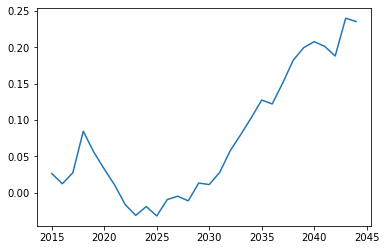

In [8]:
# set a test return
sector_returns = eigen_portfolios_test[7]
sector_returns['test_cumulative_returns'].plot()

<AxesSubplot:>

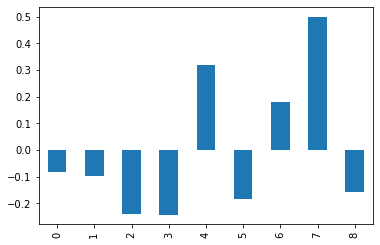

In [9]:
pd.Series(sector_returns['weights']).plot.bar()

### Preprocessing

In [9]:
## this is a bad criterion - it only seek for shocks!

## new criterion: set a target 
#fazer uma curva, se quero outperform ( exceso. de 1%) diliu essa porcentagem no tamanho da minha mostra de treino, e fazer com um grid de 1%, 2%, 3%,...... x -> grid; y -> sharpe (para cada iteração!) 

#fazer curva do sharpe em função da curva que estou procurando!
# a metrica boa é usar o sharpe e a serie



In [10]:
index_ticker ='^BVSP'

df_returns = preproc.get_normal_returns_from_prices(df_prices)
df_returns_without_index = df_returns.drop(index_ticker, axis = 1)



### setting objective

According to literature, several articles tend to beat the index by diregarding high correaltion/covariance periods replacing the drops inder certain treshold to a predefined one

For the brazilian market, different from others indexes, drops are quite severe, hnce high correlations regimes are for drops higher than 20% in the overall sample

In [67]:
# test experiment
# split in train and test
test_period = 150
train_history = 252
date = '2014-01-02'
risk_free_rate = 0.05
index_ticker ='^BVSP'
high_correlation_treshold = 0.25 # depending of the sector an statistical analysis might be performed
df_returns_train, df_returns_test = preproc.splitting_dataset_by_window(df_returns_without_index, date, train_history, test_period)



# Experiments

In [75]:
import datetime
base = datetime.datetime.strptime('2013-03-01','%Y-%m-%d')


date_iterations = [(base + datetime.timedelta(days = (30*x))).strftime('%Y-%m-%d') for x in range(10)]
grid_rate_targets = np.linspace(0.01, 0.05, num = 5)

def execute_experiment_sharpe_curves(
    date_iterations, 
    grid_rate_targets, 
    df_returns, 
    train_history = 300, 
    test_period = 30, 
    risk_free_rate = 0.05):
    
    experiments_cache = {}
    for _date in date_iterations:
        ##### preprocessing ####
        df_returns_train, df_returns_test = preproc.splitting_dataset_by_window(df_returns, _date, train_history, test_period)
        df_returns_train = df_returns_train[1:].copy()
        # y_train
        y_train = eg_functions.get_portfolio_returns(df_returns_train, sector_returns['weights'], is_log = False)
        # y_test
        y_test = eg_functions.get_portfolio_returns(df_returns_test, sector_returns['weights'], is_log = False)
        rate_sharpes_cache = {}
        for rate_target in grid_rate_targets:
            y_train_amended = set_target_spreaded_rate(y_train, rate_target)
            y_test_amended = set_target_spreaded_rate(y_test, rate_target)
            #### training part ####
            encoder_params = {'encoding_dim': 9,
                      'optimizer':'sgd', 
                      'loss':'mean_squared_error',
                      'l2_penalty': 0.01, 
                      'epochs': 500, 
                      'batch_size': 100, 
                      'shuffle' : False,
                      'output_activation': 'softmax'}
            model = autoencoder_portfolio_calibration_fit(df_returns_train, y_train_amended, encoder_params)
            #### predict ####
            #train
            portfolio_returns_train_hat = pd.Series(portfolio_returns_predict(df_returns_train, model))
            #test
            portfolio_returns_test_hat = pd.Series(portfolio_returns_predict(df_returns_test.dropna(), model))
            #cumulative test
            lp_test =  ((y_test + 1).cumprod())
            lp_test_ammended =  ((y_test_amended + 1).cumprod())
            lp_predicted_test = ((portfolio_returns_test_hat  + 1).cumprod()) 
            #cumulative train
            lp_train =  ((y_train + 1).cumprod())
            lp_train_ammended =  ((y_train_amended + 1).cumprod())
            lp_predicted_train = ((portfolio_returns_train_hat  + 1).cumprod()) 
            # sharpe ratios
            sharpe_value_predicted = eg_functions.get_portfolio_sharpe_ratio(lp_predicted_test, portfolio_returns_test_hat, risk_free_rate)
            sharpe_value_ref =  eg_functions.get_portfolio_sharpe_ratio(lp_test, y_test, risk_free_rate)
            rate_sharpes_cache[rate_target] = {
                                                'sharpe_predicted': sharpe_value_predicted,
                                                'sharpe_value_ref': sharpe_value_ref 
                                              }
        experiments_cache[_date] = rate_sharpes_cache
    return experiments_cache


experiments_sharpe_cache = execute_experiment_sharpe_curves(
                                date_iterations, 
                                grid_rate_targets, 
                                df_returns_without_index, 
                                train_history = 300, 
                                test_period = 30)


Epoch 1/500
1/1 [==============================] - 0s 17ms/step - loss: 0.7720
Epoch 2/500
1/1 [==============================] - 0s 20ms/step - loss: 0.7719
Epoch 3/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7717
Epoch 4/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7716
Epoch 5/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7714
Epoch 6/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7713
Epoch 7/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7712
Epoch 8/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7710
Epoch 9/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7709
Epoch 10/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7707
Epoch 11/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7706
Epoch 12/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7704
Epoch 13/500
1/1 [==============================]

1/1 [==============================] - 0s 12ms/step - loss: 0.7449
Epoch 205/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7448
Epoch 206/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7447
Epoch 207/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7445
Epoch 208/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7444
Epoch 209/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7443
Epoch 210/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7442
Epoch 211/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7440
Epoch 212/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7439
Epoch 213/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7438
Epoch 214/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7437
Epoch 215/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7435
Epoch 216/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7217
Epoch 407/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7216
Epoch 408/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7215
Epoch 409/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7214
Epoch 410/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7213
Epoch 411/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7212
Epoch 412/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7211
Epoch 413/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7210
Epoch 414/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7209
Epoch 415/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7208
Epoch 416/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7207
Epoch 417/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7206
Epoch 418/500
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.7456
Epoch 109/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7455
Epoch 110/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7454
Epoch 111/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7453
Epoch 112/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7452
Epoch 113/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7451
Epoch 114/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7449
Epoch 115/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7448
Epoch 116/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7447
Epoch 117/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7446
Epoch 118/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7445
Epoch 119/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7444
Epoch 120/500
1/1 [=======================

1/1 [==============================] - 0s 14ms/step - loss: 0.7236
Epoch 311/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7235
Epoch 312/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7234
Epoch 313/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7233
Epoch 314/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7232
Epoch 315/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7231
Epoch 316/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7230
Epoch 317/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7229
Epoch 318/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7228
Epoch 319/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7227
Epoch 320/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7226
Epoch 321/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7225
Epoch 322/500
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.7814
Epoch 12/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7813
Epoch 13/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7811
Epoch 14/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7810
Epoch 15/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7808
Epoch 16/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7806
Epoch 17/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7805
Epoch 18/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7803
Epoch 19/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7801
Epoch 20/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7800
Epoch 21/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7798
Epoch 22/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7797
Epoch 23/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.7509
Epoch 215/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7507
Epoch 216/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7506
Epoch 217/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7505
Epoch 218/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7503
Epoch 219/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7502
Epoch 220/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7501
Epoch 221/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7499
Epoch 222/500
1/1 [==============================] - 0s 20ms/step - loss: 0.7498
Epoch 223/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7496
Epoch 224/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7495
Epoch 225/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7494
Epoch 226/500
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.7249
Epoch 417/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7248
Epoch 418/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7247
Epoch 419/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7246
Epoch 420/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7244
Epoch 421/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7243
Epoch 422/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7242
Epoch 423/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7241
Epoch 424/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7240
Epoch 425/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7238
Epoch 426/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7237
Epoch 427/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7236
Epoch 428/500
1/1 [=======================

1/1 [==============================] - 0s 14ms/step - loss: 0.7183
Epoch 119/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7182
Epoch 120/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7181
Epoch 121/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7180
Epoch 122/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7179
Epoch 123/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7178
Epoch 124/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7177
Epoch 125/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7176
Epoch 126/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7175
Epoch 127/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7174
Epoch 128/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7173
Epoch 129/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7172
Epoch 130/500
1/1 [=======================

1/1 [==============================] - 0s 15ms/step - loss: 0.6994
Epoch 321/500
1/1 [==============================] - 0s 13ms/step - loss: 0.6993
Epoch 322/500
1/1 [==============================] - 0s 13ms/step - loss: 0.6992
Epoch 323/500
1/1 [==============================] - 0s 12ms/step - loss: 0.6991
Epoch 324/500
1/1 [==============================] - 0s 12ms/step - loss: 0.6990
Epoch 325/500
1/1 [==============================] - 0s 13ms/step - loss: 0.6989
Epoch 326/500
1/1 [==============================] - 0s 12ms/step - loss: 0.6989
Epoch 327/500
1/1 [==============================] - 0s 12ms/step - loss: 0.6988
Epoch 328/500
1/1 [==============================] - 0s 12ms/step - loss: 0.6987
Epoch 329/500
1/1 [==============================] - 0s 11ms/step - loss: 0.6986
Epoch 330/500
1/1 [==============================] - 0s 12ms/step - loss: 0.6985
Epoch 331/500
1/1 [==============================] - 0s 12ms/step - loss: 0.6984
Epoch 332/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7645
Epoch 13/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7644
Epoch 14/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7642
Epoch 15/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7641
Epoch 16/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7640
Epoch 17/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7638
Epoch 18/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7637
Epoch 19/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7635
Epoch 20/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7634
Epoch 21/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7632
Epoch 22/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7631
Epoch 23/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7630
Epoch 24/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 13ms/step - loss: 0.7377
Epoch 216/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7375
Epoch 217/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7374
Epoch 218/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7373
Epoch 219/500
1/1 [==============================] - 0s 17ms/step - loss: 0.7372
Epoch 220/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7371
Epoch 221/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7369
Epoch 222/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7368
Epoch 223/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7367
Epoch 224/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7366
Epoch 225/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7364
Epoch 226/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7363
Epoch 227/500
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.7145
Epoch 418/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7144
Epoch 419/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7143
Epoch 420/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7142
Epoch 421/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7140
Epoch 422/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7139
Epoch 423/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7138
Epoch 424/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7137
Epoch 425/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7136
Epoch 426/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7135
Epoch 427/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7134
Epoch 428/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7133
Epoch 429/500
1/1 [=======================

1/1 [==============================] - 0s 14ms/step - loss: 0.7672
Epoch 111/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7671
Epoch 112/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7670
Epoch 113/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7668
Epoch 114/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7667
Epoch 115/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7665
Epoch 116/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7664
Epoch 117/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7662
Epoch 118/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7661
Epoch 119/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7660
Epoch 120/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7658
Epoch 121/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7657
Epoch 122/500
1/1 [=======================

1/1 [==============================] - 0s 14ms/step - loss: 0.7410
Epoch 313/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7409
Epoch 314/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7408
Epoch 315/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7407
Epoch 316/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7406
Epoch 317/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7405
Epoch 318/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7403
Epoch 319/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7402
Epoch 320/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7401
Epoch 321/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7400
Epoch 322/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7399
Epoch 323/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7398
Epoch 324/500
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.7817
Epoch 14/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7815
Epoch 15/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7814
Epoch 16/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7813
Epoch 17/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7811
Epoch 18/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7810
Epoch 19/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7809
Epoch 20/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7807
Epoch 21/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7806
Epoch 22/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7805
Epoch 23/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7803
Epoch 24/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7802
Epoch 25/500
1/1 [==============================] - 0s 9ms

1/1 [==============================] - 0s 14ms/step - loss: 0.7560
Epoch 217/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7559
Epoch 218/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7558
Epoch 219/500
1/1 [==============================] - 0s 22ms/step - loss: 0.7557
Epoch 220/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7556
Epoch 221/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7554
Epoch 222/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7553
Epoch 223/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7552
Epoch 224/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7551
Epoch 225/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7550
Epoch 226/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7549
Epoch 227/500
1/1 [==============================] - 0s 19ms/step - loss: 0.7547
Epoch 228/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7336
Epoch 419/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7335
Epoch 420/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7334
Epoch 421/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7333
Epoch 422/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7332
Epoch 423/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7331
Epoch 424/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7330
Epoch 425/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7329
Epoch 426/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7328
Epoch 427/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7327
Epoch 428/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7326
Epoch 429/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7324
Epoch 430/500
1/1 [===========================

1/1 [==============================] - 0s 10ms/step - loss: 0.7668
Epoch 121/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7667
Epoch 122/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7666
Epoch 123/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7664
Epoch 124/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7663
Epoch 125/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7662
Epoch 126/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7660
Epoch 127/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7659
Epoch 128/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7658
Epoch 129/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7657
Epoch 130/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7655
Epoch 131/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7654
Epoch 132/500
1/1 [========================

1/1 [==============================] - 0s 10ms/step - loss: 0.7423
Epoch 323/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7422
Epoch 324/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7421
Epoch 325/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7419
Epoch 326/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7418
Epoch 327/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7417
Epoch 328/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7416
Epoch 329/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7415
Epoch 330/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7414
Epoch 331/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7413
Epoch 332/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7411
Epoch 333/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7410
Epoch 334/500
1/1 [========================

1/1 [==============================] - 0s 13ms/step - loss: 0.7420
Epoch 24/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7419
Epoch 25/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7418
Epoch 26/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7416
Epoch 27/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7415
Epoch 28/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7414
Epoch 29/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7413
Epoch 30/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7412
Epoch 31/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7411
Epoch 32/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7410
Epoch 33/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7409
Epoch 34/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7408
Epoch 35/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 14ms/step - loss: 0.7219
Epoch 227/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7218
Epoch 228/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7217
Epoch 229/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7216
Epoch 230/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7215
Epoch 231/500
1/1 [==============================] - 0s 17ms/step - loss: 0.7214
Epoch 232/500
1/1 [==============================] - 0s 19ms/step - loss: 0.7213
Epoch 233/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7212
Epoch 234/500
1/1 [==============================] - 0s 18ms/step - loss: 0.7211
Epoch 235/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7210
Epoch 236/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7209
Epoch 237/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7208
Epoch 238/500
1/1 [=======================

1/1 [==============================] - 0s 15ms/step - loss: 0.7038
Epoch 429/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7037
Epoch 430/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7037
Epoch 431/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7036
Epoch 432/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7035
Epoch 433/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7034
Epoch 434/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7033
Epoch 435/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7032
Epoch 436/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7032
Epoch 437/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7031
Epoch 438/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7030
Epoch 439/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7029
Epoch 440/500
1/1 [=======================

1/1 [==============================] - 0s 14ms/step - loss: 0.7753
Epoch 131/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7752
Epoch 132/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7751
Epoch 133/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7750
Epoch 134/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7748
Epoch 135/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7747
Epoch 136/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7746
Epoch 137/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7745
Epoch 138/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7744
Epoch 139/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7742
Epoch 140/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7741
Epoch 141/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7740
Epoch 142/500
1/1 [=======================

1/1 [==============================] - 0s 14ms/step - loss: 0.7521
Epoch 333/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7520
Epoch 334/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7519
Epoch 335/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7518
Epoch 336/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7517
Epoch 337/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7516
Epoch 338/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7515
Epoch 339/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7514
Epoch 340/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7513
Epoch 341/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7512
Epoch 342/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7511
Epoch 343/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7509
Epoch 344/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7870
Epoch 34/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7868
Epoch 35/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7867
Epoch 36/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7866
Epoch 37/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7864
Epoch 38/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7863
Epoch 39/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7862
Epoch 40/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7860
Epoch 41/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7859
Epoch 42/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7858
Epoch 43/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7856
Epoch 44/500
1/1 [==============================] - 0s 18ms/step - loss: 0.7855
Epoch 45/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 13ms/step - loss: 0.7737
Epoch 136/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7736
Epoch 137/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7735
Epoch 138/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7734
Epoch 139/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7732
Epoch 140/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7731
Epoch 141/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7730
Epoch 142/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7729
Epoch 143/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7727
Epoch 144/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7726
Epoch 145/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7725
Epoch 146/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7724
Epoch 147/500
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.7501
Epoch 338/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7500
Epoch 339/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7499
Epoch 340/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7497
Epoch 341/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7496
Epoch 342/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7495
Epoch 343/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7494
Epoch 344/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7493
Epoch 345/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7492
Epoch 346/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7491
Epoch 347/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7490
Epoch 348/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7489
Epoch 349/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7709
Epoch 39/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7708
Epoch 40/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7706
Epoch 41/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7705
Epoch 42/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7704
Epoch 43/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7703
Epoch 44/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7702
Epoch 45/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7701
Epoch 46/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7700
Epoch 47/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7698
Epoch 48/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7697
Epoch 49/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7696
Epoch 50/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.7595
Epoch 141/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7594
Epoch 142/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7593
Epoch 143/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7592
Epoch 144/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7591
Epoch 145/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7590
Epoch 146/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7588
Epoch 147/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7587
Epoch 148/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7586
Epoch 149/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7585
Epoch 150/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7584
Epoch 151/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7583
Epoch 152/500
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.7386
Epoch 343/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7385
Epoch 344/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7384
Epoch 345/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7383
Epoch 346/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7382
Epoch 347/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7381
Epoch 348/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7380
Epoch 349/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7379
Epoch 350/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7378
Epoch 351/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7377
Epoch 352/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7376
Epoch 353/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7375
Epoch 354/500
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8029
Epoch 44/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8028
Epoch 45/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8027
Epoch 46/500
1/1 [==============================] - 0s 12ms/step - loss: 0.8025
Epoch 47/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8024
Epoch 48/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8022
Epoch 49/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8021
Epoch 50/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8020
Epoch 51/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8018
Epoch 52/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8017
Epoch 53/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8016
Epoch 54/500
1/1 [==============================] - 0s 12ms/step - loss: 0.8014
Epoch 55/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.7898
Epoch 146/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7897
Epoch 147/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7896
Epoch 148/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7895
Epoch 149/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7893
Epoch 150/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7892
Epoch 151/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7891
Epoch 152/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7890
Epoch 153/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7888
Epoch 154/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7887
Epoch 155/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7886
Epoch 156/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7885
Epoch 157/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7668
Epoch 348/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7667
Epoch 349/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7666
Epoch 350/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7665
Epoch 351/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7664
Epoch 352/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7663
Epoch 353/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7662
Epoch 354/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7661
Epoch 355/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7660
Epoch 356/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7659
Epoch 357/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7658
Epoch 358/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7657
Epoch 359/500
1/1 [=======================

1/1 [==============================] - 0s 15ms/step - loss: 0.8014
Epoch 49/500
1/1 [==============================] - 0s 16ms/step - loss: 0.8012
Epoch 50/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8011
Epoch 51/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8009
Epoch 52/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8008
Epoch 53/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8007
Epoch 54/500
1/1 [==============================] - 0s 15ms/step - loss: 0.8005
Epoch 55/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8004
Epoch 56/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8003
Epoch 57/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8001
Epoch 58/500
1/1 [==============================] - 0s 16ms/step - loss: 0.8000
Epoch 59/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7999
Epoch 60/500
1/1 [==============================] - 0

Epoch 150/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7878
Epoch 151/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7877
Epoch 152/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7875
Epoch 153/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7874
Epoch 154/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7873
Epoch 155/500
1/1 [==============================] - 0s 17ms/step - loss: 0.7871
Epoch 156/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7870
Epoch 157/500
1/1 [==============================] - 0s 34ms/step - loss: 0.7869
Epoch 158/500
1/1 [==============================] - 0s 27ms/step - loss: 0.7868
Epoch 159/500
1/1 [==============================] - 0s 18ms/step - loss: 0.7866
Epoch 160/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7865
Epoch 161/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7864
Epoch 162/500
1/1 [=========

1/1 [==============================] - 0s 14ms/step - loss: 0.7751
Epoch 252/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7750
Epoch 253/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7749
Epoch 254/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7748
Epoch 255/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7747
Epoch 256/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7745
Epoch 257/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7744
Epoch 258/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7743
Epoch 259/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7742
Epoch 260/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7740
Epoch 261/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7739
Epoch 262/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7738
Epoch 263/500
1/1 [=======================

1/1 [==============================] - 0s 14ms/step - loss: 0.7519
Epoch 454/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7518
Epoch 455/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7517
Epoch 456/500
1/1 [==============================] - 0s 17ms/step - loss: 0.7516
Epoch 457/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7514
Epoch 458/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7513
Epoch 459/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7512
Epoch 460/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7511
Epoch 461/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7510
Epoch 462/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7509
Epoch 463/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7508
Epoch 464/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7507
Epoch 465/500
1/1 [=======================

1/1 [==============================] - 0s 16ms/step - loss: 0.7649
Epoch 155/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7648
Epoch 156/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7647
Epoch 157/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7646
Epoch 158/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7645
Epoch 159/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7644
Epoch 160/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7643
Epoch 161/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7642
Epoch 162/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7641
Epoch 163/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7640
Epoch 164/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7638
Epoch 165/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7637
Epoch 166/500
1/1 [=======================

1/1 [==============================] - 0s 17ms/step - loss: 0.7447
Epoch 357/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7446
Epoch 358/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7445
Epoch 359/500
1/1 [==============================] - 0s 36ms/step - loss: 0.7444
Epoch 360/500
1/1 [==============================] - 0s 21ms/step - loss: 0.7443
Epoch 361/500
1/1 [==============================] - 0s 19ms/step - loss: 0.7442
Epoch 362/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7441
Epoch 363/500
1/1 [==============================] - 0s 22ms/step - loss: 0.7440
Epoch 364/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7439
Epoch 365/500
1/1 [==============================] - 0s 39ms/step - loss: 0.7438
Epoch 366/500
1/1 [==============================] - 0s 23ms/step - loss: 0.7437
Epoch 367/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7436
Epoch 368/500
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.7803
Epoch 58/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7802
Epoch 59/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7801
Epoch 60/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7799
Epoch 61/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7798
Epoch 62/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7796
Epoch 63/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7795
Epoch 64/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7793
Epoch 65/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7792
Epoch 66/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7790
Epoch 67/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7789
Epoch 68/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7788
Epoch 69/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 15ms/step - loss: 0.7539
Epoch 260/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7538
Epoch 261/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7537
Epoch 262/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7536
Epoch 263/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7535
Epoch 264/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7533
Epoch 265/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7532
Epoch 266/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7531
Epoch 267/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7530
Epoch 268/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7529
Epoch 269/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7528
Epoch 270/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7526
Epoch 271/500
1/1 [=======================

1/1 [==============================] - 0s 14ms/step - loss: 0.7321
Epoch 462/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7320
Epoch 463/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7319
Epoch 464/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7318
Epoch 465/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7317
Epoch 466/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7316
Epoch 467/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7315
Epoch 468/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7314
Epoch 469/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7314
Epoch 470/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7313
Epoch 471/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7312
Epoch 472/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7311
Epoch 473/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7747
Epoch 163/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7746
Epoch 164/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7744
Epoch 165/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7743
Epoch 166/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7742
Epoch 167/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7741
Epoch 168/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7740
Epoch 169/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7739
Epoch 170/500
1/1 [==============================] - 0s 30ms/step - loss: 0.7738
Epoch 171/500
1/1 [==============================] - 0s 20ms/step - loss: 0.7737
Epoch 172/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7736
Epoch 173/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7734
Epoch 174/500
1/1 [=======================

1/1 [==============================] - 0s 14ms/step - loss: 0.7533
Epoch 365/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7532
Epoch 366/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7531
Epoch 367/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7530
Epoch 368/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7529
Epoch 369/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7528
Epoch 370/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7527
Epoch 371/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7526
Epoch 372/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7525
Epoch 373/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7524
Epoch 374/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7523
Epoch 375/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7522
Epoch 376/500
1/1 [=======================

Epoch 66/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8079
Epoch 67/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8077
Epoch 68/500
1/1 [==============================] - 0s 15ms/step - loss: 0.8076
Epoch 69/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8074
Epoch 70/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8073
Epoch 71/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8071
Epoch 72/500
1/1 [==============================] - 0s 15ms/step - loss: 0.8070
Epoch 73/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8068
Epoch 74/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8067
Epoch 75/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8065
Epoch 76/500
1/1 [==============================] - 0s 13ms/step - loss: 0.8064
Epoch 77/500
1/1 [==============================] - 0s 14ms/step - loss: 0.8062
Epoch 78/500
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7797
Epoch 269/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7796
Epoch 270/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7794
Epoch 271/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7793
Epoch 272/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7792
Epoch 273/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7790
Epoch 274/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7789
Epoch 275/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7788
Epoch 276/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7787
Epoch 277/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7785
Epoch 278/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7784
Epoch 279/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7783
Epoch 280/500
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.7557
Epoch 471/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7555
Epoch 472/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7554
Epoch 473/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7553
Epoch 474/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7552
Epoch 475/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7551
Epoch 476/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7550
Epoch 477/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7549
Epoch 478/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7548
Epoch 479/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7547
Epoch 480/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7545
Epoch 481/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7544
Epoch 482/500
1/1 [=======================

1/1 [==============================] - 0s 14ms/step - loss: 0.7950
Epoch 72/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7949
Epoch 73/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7948
Epoch 74/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7947
Epoch 75/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7945
Epoch 76/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7944
Epoch 77/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7943
Epoch 78/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7942
Epoch 79/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7941
Epoch 80/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7939
Epoch 81/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7938
Epoch 82/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7937
Epoch 83/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 15ms/step - loss: 0.7718
Epoch 274/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7717
Epoch 275/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7716
Epoch 276/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7715
Epoch 277/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7714
Epoch 278/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7713
Epoch 279/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7712
Epoch 280/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7710
Epoch 281/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7709
Epoch 282/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7708
Epoch 283/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7707
Epoch 284/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7706
Epoch 285/500
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.7510
Epoch 476/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7509
Epoch 477/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7508
Epoch 478/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7507
Epoch 479/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7506
Epoch 480/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7506
Epoch 481/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7505
Epoch 482/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7504
Epoch 483/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7503
Epoch 484/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7502
Epoch 485/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7501
Epoch 486/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7500
Epoch 487/500
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.7898
Epoch 77/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7897
Epoch 78/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7896
Epoch 79/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7895
Epoch 80/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7893
Epoch 81/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7892
Epoch 82/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7891
Epoch 83/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7890
Epoch 84/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7888
Epoch 85/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7887
Epoch 86/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7886
Epoch 87/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7885
Epoch 88/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 14ms/step - loss: 0.7669
Epoch 279/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7668
Epoch 280/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7667
Epoch 281/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7666
Epoch 282/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7665
Epoch 283/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7664
Epoch 284/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7663
Epoch 285/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7661
Epoch 286/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7660
Epoch 287/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7659
Epoch 288/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7658
Epoch 289/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7657
Epoch 290/500
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.7465
Epoch 481/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7465
Epoch 482/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7464
Epoch 483/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7463
Epoch 484/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7462
Epoch 485/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7461
Epoch 486/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7460
Epoch 487/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7459
Epoch 488/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7458
Epoch 489/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7457
Epoch 490/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7456
Epoch 491/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7455
Epoch 492/500
1/1 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8866
Epoch 82/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8863
Epoch 83/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8860
Epoch 84/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8857
Epoch 85/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8854
Epoch 86/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8851
Epoch 87/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8848
Epoch 88/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8845
Epoch 89/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8842
Epoch 90/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8839
Epoch 91/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8836
Epoch 92/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8833
Epoch 93/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 12ms/step - loss: 0.8341
Epoch 284/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8338
Epoch 285/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8336
Epoch 286/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8334
Epoch 287/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8332
Epoch 288/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8329
Epoch 289/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8327
Epoch 290/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8325
Epoch 291/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8323
Epoch 292/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8320
Epoch 293/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8318
Epoch 294/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8316
Epoch 295/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.7931
Epoch 486/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7929
Epoch 487/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7927
Epoch 488/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7926
Epoch 489/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7924
Epoch 490/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7922
Epoch 491/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7920
Epoch 492/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7918
Epoch 493/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7917
Epoch 494/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7915
Epoch 495/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7913
Epoch 496/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7911
Epoch 497/500
2/2 [=======================

2/2 [==============================] - 0s 13ms/step - loss: 0.8442
Epoch 188/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8440
Epoch 189/500
2/2 [==============================] - 0s 24ms/step - loss: 0.8437
Epoch 190/500
2/2 [==============================] - 0s 17ms/step - loss: 0.8434
Epoch 191/500
2/2 [==============================] - 0s 39ms/step - loss: 0.8431
Epoch 192/500
2/2 [==============================] - 0s 18ms/step - loss: 0.8428
Epoch 193/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8425
Epoch 194/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8423
Epoch 195/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8420
Epoch 196/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8417
Epoch 197/500
2/2 [==============================] - 0s 16ms/step - loss: 0.8414
Epoch 198/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8412
Epoch 199/500
2/2 [=======================

2/2 [==============================] - 0s 12ms/step - loss: 0.7934
Epoch 390/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7931
Epoch 391/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7929
Epoch 392/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7927
Epoch 393/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7925
Epoch 394/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7923
Epoch 395/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7921
Epoch 396/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7918
Epoch 397/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7916
Epoch 398/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7914
Epoch 399/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7912
Epoch 400/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7910
Epoch 401/500
2/2 [=======================

2/2 [==============================] - 0s 13ms/step - loss: 0.8504
Epoch 92/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8501
Epoch 93/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8498
Epoch 94/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8496
Epoch 95/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8493
Epoch 96/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8491
Epoch 97/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8488
Epoch 98/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8485
Epoch 99/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8483
Epoch 100/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8480
Epoch 101/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8477
Epoch 102/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8475
Epoch 103/500
2/2 [==============================]

2/2 [==============================] - 0s 12ms/step - loss: 0.8034
Epoch 294/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8032
Epoch 295/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8030
Epoch 296/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8028
Epoch 297/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8026
Epoch 298/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8024
Epoch 299/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8022
Epoch 300/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8020
Epoch 301/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8018
Epoch 302/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8016
Epoch 303/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8014
Epoch 304/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8012
Epoch 305/500
2/2 [=======================

2/2 [==============================] - 0s 12ms/step - loss: 0.7671
Epoch 496/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7669
Epoch 497/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7668
Epoch 498/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7666
Epoch 499/500
2/2 [==============================] - 0s 20ms/step - loss: 0.7665
Epoch 500/500
1/1 [==============================] - 0s 21ms/step
Epoch 1/500
2/2 [==============================] - 0s 10ms/step - loss: 0.9174
Epoch 2/500
2/2 [==============================] - 0s 10ms/step - loss: 0.9170
Epoch 3/500
2/2 [==============================] - 0s 11ms/step - loss: 0.9166
Epoch 4/500
2/2 [==============================] - 0s 11ms/step - loss: 0.9163
Epoch 5/500
2/2 [==============================] - 0s 11ms/step - loss: 0.9159
Epoch 6/500
2/2 [==============================] - 0s 11ms/step - loss: 0.9155
Epoch 7/500
2/2 [==============================] - 0s 12ms/step - los

2/2 [==============================] - 0s 11ms/step - loss: 0.8546
Epoch 198/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8544
Epoch 199/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8541
Epoch 200/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8538
Epoch 201/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8535
Epoch 202/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8533
Epoch 203/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8530
Epoch 204/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8527
Epoch 205/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8525
Epoch 206/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8522
Epoch 207/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8519
Epoch 208/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8516
Epoch 209/500
2/2 [=======================

2/2 [==============================] - 0s 12ms/step - loss: 0.8059
Epoch 400/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8057
Epoch 401/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8055
Epoch 402/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8053
Epoch 403/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8051
Epoch 404/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8049
Epoch 405/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8047
Epoch 406/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8044
Epoch 407/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8042
Epoch 408/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8040
Epoch 409/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8038
Epoch 410/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8036
Epoch 411/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.8865
Epoch 102/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8862
Epoch 103/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8859
Epoch 104/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8856
Epoch 105/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8853
Epoch 106/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8850
Epoch 107/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8847
Epoch 108/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8844
Epoch 109/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8841
Epoch 110/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8838
Epoch 111/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8835
Epoch 112/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8832
Epoch 113/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8314
Epoch 304/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8312
Epoch 305/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8310
Epoch 306/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8307
Epoch 307/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8305
Epoch 308/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8303
Epoch 309/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8300
Epoch 310/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8298
Epoch 311/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8296
Epoch 312/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8293
Epoch 313/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8291
Epoch 314/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8289
Epoch 315/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8966
Epoch 5/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8964
Epoch 6/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8961
Epoch 7/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8959
Epoch 8/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8956
Epoch 9/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8953
Epoch 10/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8951
Epoch 11/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8948
Epoch 12/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8946
Epoch 13/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8943
Epoch 14/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8941
Epoch 15/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8938
Epoch 16/500
2/2 [==============================] - 0s 12m

2/2 [==============================] - 0s 10ms/step - loss: 0.8485
Epoch 208/500
2/2 [==============================] - 0s 8ms/step - loss: 0.8483
Epoch 209/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8481
Epoch 210/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8478
Epoch 211/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8476
Epoch 212/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8474
Epoch 213/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8472
Epoch 214/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8470
Epoch 215/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8468
Epoch 216/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8465
Epoch 217/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8463
Epoch 218/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8461
Epoch 219/500
2/2 [=========================

2/2 [==============================] - 0s 10ms/step - loss: 0.8076
Epoch 410/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8074
Epoch 411/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8073
Epoch 412/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8071
Epoch 413/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8069
Epoch 414/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8067
Epoch 415/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8065
Epoch 416/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8063
Epoch 417/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8061
Epoch 418/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8060
Epoch 419/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8058
Epoch 420/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8056
Epoch 421/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8907
Epoch 112/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8904
Epoch 113/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8901
Epoch 114/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8899
Epoch 115/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8896
Epoch 116/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8893
Epoch 117/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8890
Epoch 118/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8887
Epoch 119/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8884
Epoch 120/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8882
Epoch 121/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8879
Epoch 122/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8876
Epoch 123/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8407
Epoch 314/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8405
Epoch 315/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8402
Epoch 316/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8400
Epoch 317/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8398
Epoch 318/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8396
Epoch 319/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8394
Epoch 320/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8392
Epoch 321/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8390
Epoch 322/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8388
Epoch 323/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 324/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8383
Epoch 325/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8842
Epoch 15/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8840
Epoch 16/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8837
Epoch 17/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8835
Epoch 18/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8833
Epoch 19/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8830
Epoch 20/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8828
Epoch 21/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8826
Epoch 22/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8823
Epoch 23/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8821
Epoch 24/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8819
Epoch 25/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8816
Epoch 26/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 12ms/step - loss: 0.8395
Epoch 218/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8393
Epoch 219/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8391
Epoch 220/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8389
Epoch 221/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8387
Epoch 222/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 223/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8383
Epoch 224/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8381
Epoch 225/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8379
Epoch 226/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8377
Epoch 227/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8375
Epoch 228/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8373
Epoch 229/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8008
Epoch 420/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8006
Epoch 421/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8005
Epoch 422/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8003
Epoch 423/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8001
Epoch 424/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7999
Epoch 425/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7997
Epoch 426/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7996
Epoch 427/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7994
Epoch 428/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7992
Epoch 429/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7990
Epoch 430/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7989
Epoch 431/500
2/2 [=======================

2/2 [==============================] - 0s 12ms/step - loss: 0.8619
Epoch 122/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8617
Epoch 123/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8615
Epoch 124/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8613
Epoch 125/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8611
Epoch 126/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8609
Epoch 127/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8606
Epoch 128/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8604
Epoch 129/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8602
Epoch 130/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8600
Epoch 131/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8598
Epoch 132/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8596
Epoch 133/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8225
Epoch 324/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8224
Epoch 325/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8222
Epoch 326/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8220
Epoch 327/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8218
Epoch 328/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8216
Epoch 329/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8215
Epoch 330/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8213
Epoch 331/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8211
Epoch 332/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8209
Epoch 333/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8207
Epoch 334/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8206
Epoch 335/500
2/2 [=======================

2/2 [==============================] - 0s 14ms/step - loss: 0.8794
Epoch 25/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8792
Epoch 26/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8790
Epoch 27/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8787
Epoch 28/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8785
Epoch 29/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8783
Epoch 30/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8781
Epoch 31/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8778
Epoch 32/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8776
Epoch 33/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8774
Epoch 34/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8771
Epoch 35/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8769
Epoch 36/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 10ms/step - loss: 0.8379
Epoch 228/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8377
Epoch 229/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8375
Epoch 230/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8374
Epoch 231/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8372
Epoch 232/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8370
Epoch 233/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8368
Epoch 234/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8366
Epoch 235/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8364
Epoch 236/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8363
Epoch 237/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8361
Epoch 238/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8359
Epoch 239/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8039
Epoch 430/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8037
Epoch 431/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8036
Epoch 432/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8034
Epoch 433/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8032
Epoch 434/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8031
Epoch 435/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8029
Epoch 436/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8028
Epoch 437/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8026
Epoch 438/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8025
Epoch 439/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8023
Epoch 440/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8022
Epoch 441/500
2/2 [=======================

Epoch 30/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8732
Epoch 31/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8729
Epoch 32/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8726
Epoch 33/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8723
Epoch 34/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8720
Epoch 35/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8717
Epoch 36/500
2/2 [==============================] - 0s 18ms/step - loss: 0.8714
Epoch 37/500
2/2 [==============================] - 0s 18ms/step - loss: 0.8711
Epoch 38/500
2/2 [==============================] - 0s 18ms/step - loss: 0.8708
Epoch 39/500
2/2 [==============================] - 0s 16ms/step - loss: 0.8706
Epoch 40/500
2/2 [==============================] - 0s 17ms/step - loss: 0.8703
Epoch 41/500
2/2 [==============================] - 0s 14ms/step - loss: 0.8700
Epoch 42/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8465
Epoch 133/500
2/2 [==============================] - 0s 16ms/step - loss: 0.8463
Epoch 134/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8460
Epoch 135/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8458
Epoch 136/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8456
Epoch 137/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8453
Epoch 138/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8451
Epoch 139/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8449
Epoch 140/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8446
Epoch 141/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8444
Epoch 142/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8442
Epoch 143/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8439
Epoch 144/500
2/2 [========================

2/2 [==============================] - 0s 10ms/step - loss: 0.8049
Epoch 335/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8047
Epoch 336/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8045
Epoch 337/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8043
Epoch 338/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8042
Epoch 339/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8040
Epoch 340/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8038
Epoch 341/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8036
Epoch 342/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8034
Epoch 343/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8033
Epoch 344/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8031
Epoch 345/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8029
Epoch 346/500
2/2 [========================

2/2 [==============================] - 0s 9ms/step - loss: 0.8511
Epoch 37/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8509
Epoch 38/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8507
Epoch 39/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8504
Epoch 40/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8502
Epoch 41/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8499
Epoch 42/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8497
Epoch 43/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8494
Epoch 44/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8492
Epoch 45/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8489
Epoch 46/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8487
Epoch 47/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8485
Epoch 48/500
2/2 [==============================] - 0s 10ms/step

2/2 [==============================] - 0s 13ms/step - loss: 0.8070
Epoch 240/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8068
Epoch 241/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8066
Epoch 242/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8064
Epoch 243/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8063
Epoch 244/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8061
Epoch 245/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8059
Epoch 246/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8057
Epoch 247/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8055
Epoch 248/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8053
Epoch 249/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8051
Epoch 250/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8049
Epoch 251/500
2/2 [=======================

2/2 [==============================] - 0s 12ms/step - loss: 0.7717
Epoch 442/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7716
Epoch 443/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7714
Epoch 444/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7713
Epoch 445/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7711
Epoch 446/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7710
Epoch 447/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7708
Epoch 448/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7706
Epoch 449/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7705
Epoch 450/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7703
Epoch 451/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7702
Epoch 452/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7700
Epoch 453/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.8159
Epoch 144/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8157
Epoch 145/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8155
Epoch 146/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8153
Epoch 147/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8151
Epoch 148/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8149
Epoch 149/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8147
Epoch 150/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8145
Epoch 151/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8143
Epoch 152/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8141
Epoch 153/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8139
Epoch 154/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8137
Epoch 155/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.7802
Epoch 346/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7801
Epoch 347/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7799
Epoch 348/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7797
Epoch 349/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7796
Epoch 350/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7794
Epoch 351/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7793
Epoch 352/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7791
Epoch 353/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7789
Epoch 354/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7788
Epoch 355/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7786
Epoch 356/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7785
Epoch 357/500
2/2 [=========================

2/2 [==============================] - 0s 12ms/step - loss: 0.8319
Epoch 47/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8317
Epoch 48/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8315
Epoch 49/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8313
Epoch 50/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8311
Epoch 51/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8309
Epoch 52/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8306
Epoch 53/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8304
Epoch 54/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8302
Epoch 55/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8300
Epoch 56/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8298
Epoch 57/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8296
Epoch 58/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 10ms/step - loss: 0.8109
Epoch 149/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8107
Epoch 150/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8105
Epoch 151/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8103
Epoch 152/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8101
Epoch 153/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8099
Epoch 154/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8097
Epoch 155/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8095
Epoch 156/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8093
Epoch 157/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8091
Epoch 158/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8089
Epoch 159/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8087
Epoch 160/500
2/2 [==============================

2/2 [==============================] - 0s 12ms/step - loss: 0.7752
Epoch 351/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7751
Epoch 352/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7749
Epoch 353/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7748
Epoch 354/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7746
Epoch 355/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7745
Epoch 356/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7743
Epoch 357/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7741
Epoch 358/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7740
Epoch 359/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7738
Epoch 360/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7737
Epoch 361/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7735
Epoch 362/500
2/2 [=======================

2/2 [==============================] - 0s 12ms/step - loss: 0.8387
Epoch 53/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 54/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 55/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8380
Epoch 56/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 57/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8376
Epoch 58/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8373
Epoch 59/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8371
Epoch 60/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8369
Epoch 61/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8366
Epoch 62/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8364
Epoch 63/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8362
Epoch 64/500
2/2 [==============================] - 0s 9m

2/2 [==============================] - 0s 13ms/step - loss: 0.7976
Epoch 256/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7974
Epoch 257/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7972
Epoch 258/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7971
Epoch 259/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7969
Epoch 260/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7967
Epoch 261/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7965
Epoch 262/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7964
Epoch 263/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7962
Epoch 264/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7960
Epoch 265/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7958
Epoch 266/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7957
Epoch 267/500
2/2 [========================

2/2 [==============================] - 0s 12ms/step - loss: 0.7652
Epoch 458/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7651
Epoch 459/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7649
Epoch 460/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7648
Epoch 461/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7646
Epoch 462/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7645
Epoch 463/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7644
Epoch 464/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7642
Epoch 465/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7641
Epoch 466/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7639
Epoch 467/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7638
Epoch 468/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7636
Epoch 469/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.8389
Epoch 59/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8386
Epoch 60/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8384
Epoch 61/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8382
Epoch 62/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8380
Epoch 63/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 64/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8376
Epoch 65/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8373
Epoch 66/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8371
Epoch 67/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8369
Epoch 68/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8367
Epoch 69/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8365
Epoch 70/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 10ms/step - loss: 0.8176
Epoch 161/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8174
Epoch 162/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8172
Epoch 163/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8170
Epoch 164/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8168
Epoch 165/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8166
Epoch 166/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8164
Epoch 167/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8162
Epoch 168/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8160
Epoch 169/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8158
Epoch 170/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8156
Epoch 171/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8154
Epoch 172/500
2/2 [=========================

2/2 [==============================] - 0s 10ms/step - loss: 0.7812
Epoch 363/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7810
Epoch 364/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7809
Epoch 365/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7807
Epoch 366/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7805
Epoch 367/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7804
Epoch 368/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7802
Epoch 369/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7800
Epoch 370/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7799
Epoch 371/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7797
Epoch 372/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7796
Epoch 373/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7794
Epoch 374/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.8337
Epoch 65/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8335
Epoch 66/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8332
Epoch 67/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8330
Epoch 68/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8328
Epoch 69/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8325
Epoch 70/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8323
Epoch 71/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8321
Epoch 72/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8318
Epoch 73/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8316
Epoch 74/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8314
Epoch 75/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8311
Epoch 76/500
2/2 [==============================] - 0

Epoch 166/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8110
Epoch 167/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8108
Epoch 168/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8106
Epoch 169/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8104
Epoch 170/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8102
Epoch 171/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8100
Epoch 172/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8098
Epoch 173/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8095
Epoch 174/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8093
Epoch 175/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8091
Epoch 176/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8089
Epoch 177/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8087
Epoch 178/500
2/2 [===============

2/2 [==============================] - 0s 11ms/step - loss: 0.7732
Epoch 369/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7730
Epoch 370/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7728
Epoch 371/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7727
Epoch 372/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7725
Epoch 373/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7723
Epoch 374/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7722
Epoch 375/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7720
Epoch 376/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7718
Epoch 377/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7717
Epoch 378/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7715
Epoch 379/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7713
Epoch 380/500
2/2 [=======================

2/2 [==============================] - 0s 9ms/step - loss: 0.8177
Epoch 71/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8175
Epoch 72/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8173
Epoch 73/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8171
Epoch 74/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8169
Epoch 75/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8167
Epoch 76/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8165
Epoch 77/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8163
Epoch 78/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8161
Epoch 79/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8159
Epoch 80/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8157
Epoch 81/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8155
Epoch 82/500
2/2 [==============================] - 0s 10m

2/2 [==============================] - 0s 10ms/step - loss: 0.7808
Epoch 275/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7807
Epoch 276/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7805
Epoch 277/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7803
Epoch 278/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7802
Epoch 279/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7800
Epoch 280/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7799
Epoch 281/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7797
Epoch 282/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7795
Epoch 283/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7794
Epoch 284/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7792
Epoch 285/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7790
Epoch 286/500
2/2 [=========================

2/2 [==============================] - 0s 10ms/step - loss: 0.7507
Epoch 478/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7505
Epoch 479/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7504
Epoch 480/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7503
Epoch 481/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7501
Epoch 482/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7500
Epoch 483/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7498
Epoch 484/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7497
Epoch 485/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7496
Epoch 486/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7494
Epoch 487/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7493
Epoch 488/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7492
Epoch 489/500
2/2 [==============================

2/2 [==============================] - 0s 10ms/step - loss: 0.8137
Epoch 80/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8135
Epoch 81/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8133
Epoch 82/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8131
Epoch 83/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8129
Epoch 84/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8127
Epoch 85/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8124
Epoch 86/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8122
Epoch 87/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8120
Epoch 88/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8118
Epoch 89/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8116
Epoch 90/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8114
Epoch 91/500
2/2 [==============================] - 0s 

2/2 [==============================] - 0s 10ms/step - loss: 0.7758
Epoch 282/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7756
Epoch 283/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7755
Epoch 284/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7753
Epoch 285/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7751
Epoch 286/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7750
Epoch 287/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7748
Epoch 288/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7746
Epoch 289/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7745
Epoch 290/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7743
Epoch 291/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7741
Epoch 292/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7740
Epoch 293/500
2/2 [=============================

2/2 [==============================] - 0s 9ms/step - loss: 0.7449
Epoch 486/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7447
Epoch 487/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7446
Epoch 488/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7445
Epoch 489/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7443
Epoch 490/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7442
Epoch 491/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7441
Epoch 492/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7439
Epoch 493/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7438
Epoch 494/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7437
Epoch 495/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7435
Epoch 496/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7434
Epoch 497/500
2/2 [==============================] - 

2/2 [==============================] - 0s 9ms/step - loss: 0.8103
Epoch 190/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8101
Epoch 191/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8098
Epoch 192/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8096
Epoch 193/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8094
Epoch 194/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8092
Epoch 195/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8090
Epoch 196/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8088
Epoch 197/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8086
Epoch 198/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8083
Epoch 199/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8081
Epoch 200/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8079
Epoch 201/500
2/2 [==============================] - 

2/2 [==============================] - 0s 9ms/step - loss: 0.7708
Epoch 394/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7706
Epoch 395/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7705
Epoch 396/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7703
Epoch 397/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7701
Epoch 398/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7699
Epoch 399/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7698
Epoch 400/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7696
Epoch 401/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7694
Epoch 402/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7693
Epoch 403/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7691
Epoch 404/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7689
Epoch 405/500
2/2 [==============================] - 

2/2 [==============================] - 0s 10ms/step - loss: 0.8088
Epoch 96/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8086
Epoch 97/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8084
Epoch 98/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8081
Epoch 99/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8079
Epoch 100/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8077
Epoch 101/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8075
Epoch 102/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8073
Epoch 103/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8071
Epoch 104/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8069
Epoch 105/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8067
Epoch 106/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8065
Epoch 107/500
2/2 [============================

2/2 [==============================] - 0s 12ms/step - loss: 0.7718
Epoch 298/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7716
Epoch 299/500
2/2 [==============================] - 0s 14ms/step - loss: 0.7715
Epoch 300/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7713
Epoch 301/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7711
Epoch 302/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7710
Epoch 303/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7708
Epoch 304/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7706
Epoch 305/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7705
Epoch 306/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7703
Epoch 307/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7702
Epoch 308/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7700
Epoch 309/500
2/2 [=======================

2/2 [==============================] - 0s 12ms/step - loss: 0.7418
Epoch 500/500
1/1 [==============================] - 0s 19ms/step
Epoch 1/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8318
Epoch 2/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8316
Epoch 3/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8313
Epoch 4/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8311
Epoch 5/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8309
Epoch 6/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8306
Epoch 7/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8304
Epoch 8/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8302
Epoch 9/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8300
Epoch 10/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8297
Epoch 11/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8

2/2 [==============================] - 0s 10ms/step - loss: 0.7909
Epoch 202/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7907
Epoch 203/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7905
Epoch 204/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7903
Epoch 205/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7901
Epoch 206/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7900
Epoch 207/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7898
Epoch 208/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7896
Epoch 209/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7894
Epoch 210/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7892
Epoch 211/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7891
Epoch 212/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7889
Epoch 213/500
2/2 [==========================

2/2 [==============================] - 0s 11ms/step - loss: 0.7575
Epoch 404/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7574
Epoch 405/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7572
Epoch 406/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7571
Epoch 407/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7569
Epoch 408/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7568
Epoch 409/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7566
Epoch 410/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7565
Epoch 411/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7563
Epoch 412/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7562
Epoch 413/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7560
Epoch 414/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7559
Epoch 415/500
2/2 [==============================]

2/2 [==============================] - 0s 13ms/step - loss: 0.8234
Epoch 107/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8231
Epoch 108/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8229
Epoch 109/500
2/2 [==============================] - 0s 16ms/step - loss: 0.8227
Epoch 110/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8224
Epoch 111/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8222
Epoch 112/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8220
Epoch 113/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8217
Epoch 114/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8215
Epoch 115/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8213
Epoch 116/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8210
Epoch 117/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8208
Epoch 118/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.7812
Epoch 309/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7810
Epoch 310/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7809
Epoch 311/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7807
Epoch 312/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7805
Epoch 313/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7803
Epoch 314/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7801
Epoch 315/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7799
Epoch 316/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7797
Epoch 317/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7796
Epoch 318/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7794
Epoch 319/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7792
Epoch 320/500
2/2 [========================

2/2 [==============================] - 0s 11ms/step - loss: 0.8248
Epoch 10/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8246
Epoch 11/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8244
Epoch 12/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8242
Epoch 13/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8240
Epoch 14/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8238
Epoch 15/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8236
Epoch 16/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8234
Epoch 17/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8232
Epoch 18/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8230
Epoch 19/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8227
Epoch 20/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8225
Epoch 21/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 9ms/step - loss: 0.7862
Epoch 213/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7860
Epoch 214/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7858
Epoch 215/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7857
Epoch 216/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7855
Epoch 217/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7853
Epoch 218/500
2/2 [==============================] - 0s 13ms/step - loss: 0.7851
Epoch 219/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7850
Epoch 220/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7848
Epoch 221/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7846
Epoch 222/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7845
Epoch 223/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7843
Epoch 224/500
2/2 [==========================

2/2 [==============================] - 0s 10ms/step - loss: 0.7545
Epoch 415/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7544
Epoch 416/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7542
Epoch 417/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7541
Epoch 418/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7540
Epoch 419/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7538
Epoch 420/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7537
Epoch 421/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7535
Epoch 422/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7534
Epoch 423/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7532
Epoch 424/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7531
Epoch 425/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7530
Epoch 426/500
2/2 [==============================]

2/2 [==============================] - 0s 10ms/step - loss: 0.8161
Epoch 118/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8159
Epoch 119/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8157
Epoch 120/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8155
Epoch 121/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8153
Epoch 122/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8150
Epoch 123/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8148
Epoch 124/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8146
Epoch 125/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8144
Epoch 126/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8142
Epoch 127/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8140
Epoch 128/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8138
Epoch 129/500
2/2 [==============================]

2/2 [==============================] - 0s 9ms/step - loss: 0.7782
Epoch 322/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7780
Epoch 323/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7779
Epoch 324/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7777
Epoch 325/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7776
Epoch 326/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7774
Epoch 327/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7772
Epoch 328/500
2/2 [==============================] - 0s 18ms/step - loss: 0.7771
Epoch 329/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7769
Epoch 330/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7767
Epoch 331/500
2/2 [==============================] - 0s 9ms/step - loss: 0.7766
Epoch 332/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7764
Epoch 333/500
2/2 [==============================]

3/3 [==============================] - 0s 8ms/step - loss: 0.8214
Epoch 25/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8210
Epoch 26/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8207
Epoch 27/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8203
Epoch 28/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8200
Epoch 29/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8197
Epoch 30/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8193
Epoch 31/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8190
Epoch 32/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8186
Epoch 33/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8183
Epoch 34/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8179
Epoch 35/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8176
Epoch 36/500
3/3 [==============================] - 0s 8ms/step -

3/3 [==============================] - 0s 8ms/step - loss: 0.7611
Epoch 230/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7608
Epoch 231/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7606
Epoch 232/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7603
Epoch 233/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7601
Epoch 234/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7598
Epoch 235/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7596
Epoch 236/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7593
Epoch 237/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7591
Epoch 238/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7589
Epoch 239/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7586
Epoch 240/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7584
Epoch 241/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.7176
Epoch 434/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7174
Epoch 435/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7172
Epoch 436/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7170
Epoch 437/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7168
Epoch 438/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7167
Epoch 439/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7165
Epoch 440/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7163
Epoch 441/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7161
Epoch 442/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7159
Epoch 443/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7158
Epoch 444/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7156
Epoch 445/500
3/3 [=============================

3/3 [==============================] - 0s 8ms/step - loss: 0.7621
Epoch 138/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7618
Epoch 139/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7615
Epoch 140/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7613
Epoch 141/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7610
Epoch 142/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7608
Epoch 143/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7605
Epoch 144/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7603
Epoch 145/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7600
Epoch 146/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7598
Epoch 147/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7595
Epoch 148/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7593
Epoch 149/500
3/3 [==============================] -

3/3 [==============================] - 0s 9ms/step - loss: 0.7180
Epoch 341/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7178
Epoch 342/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7176
Epoch 343/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7174
Epoch 344/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7172
Epoch 345/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7171
Epoch 346/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7169
Epoch 347/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7167
Epoch 348/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7165
Epoch 349/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7163
Epoch 350/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7162
Epoch 351/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7160
Epoch 352/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.7007
Epoch 443/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7006
Epoch 444/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7004
Epoch 445/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7002
Epoch 446/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7001
Epoch 447/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6999
Epoch 448/500
3/3 [==============================] - 0s 9ms/step - loss: 0.6998
Epoch 449/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6996
Epoch 450/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6995
Epoch 451/500
3/3 [==============================] - 0s 9ms/step - loss: 0.6993
Epoch 452/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6992
Epoch 453/500
3/3 [==============================] - 0s 9ms/step - loss: 0.6990
Epoch 454/500
3/3 [=============================

3/3 [==============================] - 0s 9ms/step - loss: 0.7643
Epoch 146/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7640
Epoch 147/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7638
Epoch 148/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7635
Epoch 149/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7632
Epoch 150/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7630
Epoch 151/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7627
Epoch 152/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7624
Epoch 153/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7622
Epoch 154/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7619
Epoch 155/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7616
Epoch 156/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7614
Epoch 157/500
3/3 [==========================

Epoch 349/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7186
Epoch 350/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7184
Epoch 351/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7182
Epoch 352/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7180
Epoch 353/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7178
Epoch 354/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7177
Epoch 355/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7175
Epoch 356/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7173
Epoch 357/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7171
Epoch 358/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7169
Epoch 359/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7167
Epoch 360/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7165
Epoch 361/500
3/3 [==================

3/3 [==============================] - 0s 11ms/step - loss: 0.7009
Epoch 452/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7007
Epoch 453/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7006
Epoch 454/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7004
Epoch 455/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7003
Epoch 456/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7001
Epoch 457/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6999
Epoch 458/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6998
Epoch 459/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6996
Epoch 460/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6995
Epoch 461/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6993
Epoch 462/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6991
Epoch 463/500
3/3 [=======================

3/3 [==============================] - 0s 14ms/step - loss: 0.7700
Epoch 155/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7697
Epoch 156/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7695
Epoch 157/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7692
Epoch 158/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7690
Epoch 159/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7687
Epoch 160/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7684
Epoch 161/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7682
Epoch 162/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7679
Epoch 163/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7677
Epoch 164/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7674
Epoch 165/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7672
Epoch 166/500
3/3 [========================

Epoch 358/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7250
Epoch 359/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7248
Epoch 360/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7247
Epoch 361/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7245
Epoch 362/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7243
Epoch 363/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7241
Epoch 364/500
3/3 [==============================] - 0s 15ms/step - loss: 0.7239
Epoch 365/500
3/3 [==============================] - 0s 15ms/step - loss: 0.7237
Epoch 366/500
3/3 [==============================] - 0s 14ms/step - loss: 0.7236
Epoch 367/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7234
Epoch 368/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7232
Epoch 369/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7230
Epoch 370/500
3/3 [===========

Epoch 61/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8188
Epoch 62/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8185
Epoch 63/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8182
Epoch 64/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8178
Epoch 65/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8175
Epoch 66/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8171
Epoch 67/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8168
Epoch 68/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8165
Epoch 69/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8161
Epoch 70/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8158
Epoch 71/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8154
Epoch 72/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8151
Epoch 73/500
3/3 [======================

3/3 [==============================] - 0s 9ms/step - loss: 0.7596
Epoch 266/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7593
Epoch 267/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7591
Epoch 268/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7589
Epoch 269/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7586
Epoch 270/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7584
Epoch 271/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7581
Epoch 272/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7579
Epoch 273/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7576
Epoch 274/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7574
Epoch 275/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7572
Epoch 276/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7569
Epoch 277/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 12ms/step - loss: 0.7366
Epoch 368/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7364
Epoch 369/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7362
Epoch 370/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7360
Epoch 371/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7358
Epoch 372/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7356
Epoch 373/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7354
Epoch 374/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7351
Epoch 375/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7349
Epoch 376/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7347
Epoch 377/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7345
Epoch 378/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7343
Epoch 379/500
3/3 [=======================

In [76]:
import pickle
with open('./data/experiments_sharpe_cache.pickle', 'wb') as output:
     pickle.dump(experiments_sharpe_cache, output)



In [77]:
# read experiments results

# load test results - equivalent to the index returns to compare with
import pickle
with open("./data/experiments_sharpe_cache.pickle", "rb") as infile:
    experiments_cache = pickle.load(infile)

## Metrixs distribution, sharpe ratio

In [78]:
experiments_sharpe_cache

{'2013-03-01': {0.01: {'sharpe_predicted': -4.408197445618174,
   'sharpe_value_ref': -3.9772987321017883},
  0.02: {'sharpe_predicted': -4.539725617314579,
   'sharpe_value_ref': -3.9772987321017883},
  0.03: {'sharpe_predicted': -4.730761552379947,
   'sharpe_value_ref': -3.9772987321017883},
  0.04: {'sharpe_predicted': -4.667294525326793,
   'sharpe_value_ref': -3.9772987321017883},
  0.05: {'sharpe_predicted': -4.510558011695376,
   'sharpe_value_ref': -3.9772987321017883}},
 '2013-03-31': {0.01: {'sharpe_predicted': -7.607187230495521,
   'sharpe_value_ref': -7.559571179018227},
  0.02: {'sharpe_predicted': -7.777086634197314,
   'sharpe_value_ref': -7.559571179018227},
  0.03: {'sharpe_predicted': -7.658513639775187,
   'sharpe_value_ref': -7.559571179018227},
  0.04: {'sharpe_predicted': -7.559183698013421,
   'sharpe_value_ref': -7.559571179018227},
  0.05: {'sharpe_predicted': -7.67210903978531,
   'sharpe_value_ref': -7.559571179018227}},
 '2013-04-30': {0.01: {'sharpe_predi

In [64]:

test_sharpe_values_pred, test_sharpe_values_ref = [], []
train_sharpe_values_pred, train_sharpe_values_ref = [], []


for k,v in experiments_cache.items():

    # sharpe ratio

    sharpe_value_predicted = eg_functions.get_portfolio_sharpe_ratio(v['test']['lp_predicted'], v['test']['portfolio_returns_pred'], risk_free_rate)
    sharpe_value_ref =  eg_functions.get_portfolio_sharpe_ratio(v['test']['lp'], v['test']['portfolio_returns_reference'], risk_free_rate)
    test_sharpe_values_pred.append(sharpe_value_predicted)
    test_sharpe_values_ref.append(sharpe_value_ref)
    




### deflated sharpe value
https://quantdare.com/deflated-sharpe-ratio-how-to-avoid-been-fooled-by-randomness/

As the mean is zero, there is no significant difference between the original return given by the risk factor from the eigenportfolio, which means the initial hyphotesis that non-lineraities seeked by a defined target are not found or present.

Next ideas: is go from step 1 of deepportfolios to harness least-communal stocks for the specific target!

is is random!

# methods

In [14]:
encoder_params = {'encoding_dim': 5,
                  'optimizer':'sgd', 
                  'loss':'mean_squared_error',
                  'l2_penalty': 0.001, 
                  'epochs': 500, 
                  'batch_size': 10, 
                  'shuffle' : False}


from tensorflow.python.ops import math_ops
#We used our own loss function because the one provided by tensorflow was not consistent
"""def loss(mse, regularizer, lambd, num_input, batch_size):
    with tf.compat.v1.variable_scope("loss"):
        loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)
    return loss

def mse(output, x):
    with tf.compat.v1.variable_scope('mse'):
        mse = tf.math.squared_difference(output, x)
    return mse"""

def autoencoder_portfolio_calibration_fit(x, y_target, network_params):
    
    # input autoencoder params
    encoding_dim = network_params['encoding_dim']
    l2_penalty = network_params['l2_penalty']
    optimizer =  network_params['optimizer']
    loss = network_params['loss']
    epochs = network_params['epochs']
    batch_size = network_params['batch_size']
    shuffle = network_params['shuffle'] 
    output_activation = network_params['output_activation']
    
    # target tensor -> y_target
    target = Input(shape=(1,))
    # connect all layers
    input_tensor = Input(shape=(x.shape[1],))
    encoded = Dense(encoding_dim, activation='tanh', kernel_regularizer=regularizers.l2(l2_penalty))(input_tensor)
    #decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(encoded)
    decoded = Dense(x.shape[1], activation= output_activation, kernel_regularizer=regularizers.l2(l2_penalty))(encoded)
    
    
  
    def custom_rmse_loss(y_true, y_pred, input_tensor):

        y_pred_dot = K.dot(y_pred, K.transpose(input_tensor))
        loss = K.sqrt(K.mean(K.square(y_pred_dot - y_true))) 
        
        return loss
    
 
    
    # construct and compile deep learning routine
    deep_learner = Model([input_tensor, target], decoded)
    
    deep_learner.add_loss(custom_rmse_loss(target, decoded, input_tensor))
    deep_learner.compile(optimizer=optimizer, loss = None, run_eagerly=True)
    #deep_learner.fit(x, y_target, shuffle=shuffle, epochs=epochs, batch_size = batch_size)    # fit the model
    
    ss = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    ss.fit(x)
    x = ss.transform(x)
    
    deep_learner.fit([x, y_target] , None, shuffle=shuffle, epochs=epochs, batch_size = batch_size)
    
    # this make inferences compatible
    final_model = Model(deep_learner.input[0], deep_learner.output)
    
    return final_model



def autoencoder_short_portfolio_calibration_fit(x, y_target, network_params):
    
    # input autoencoder params
    encoding_dim = network_params['encoding_dim']
    l2_penalty = network_params['l2_penalty']
    optimizer =  network_params['optimizer']
    loss = network_params['loss']
    epochs = network_params['epochs']
    batch_size = network_params['batch_size']
    shuffle = network_params['shuffle'] 
    output_activation = network_params['output_activation']
    
    # target tensor -> y_target
    target = Input(shape=(1,))
    # connect all layers
    input_tensor = Input(shape=(x.shape[1],))
    encoded = Dense(encoding_dim, activation='tanh', kernel_regularizer=regularizers.l2(l2_penalty))(input_tensor)
    #decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(encoded)
    decoded = Dense(x.shape[1], activation= output_activation, kernel_regularizer=regularizers.l2(l2_penalty))(encoded)
    return_ = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(decoded)
    
 
    # construct and compile deep learning routine
    deep_learner = Model(input_tensor, return_)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    ss = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    ss.fit(x)
    x = ss.transform(x)
    
    
    deep_learner.fit(x, y_target, shuffle=shuffle, epochs=epochs, batch_size = batch_size)    # fit the model
    

    return deep_learner


def portfolio_returns_predict(x, model):
    "Get the models weights to estimate returns"
    weights = copy.deepcopy(model.predict(x))
    x = np.array(x)
    returns = []
    for i in range(len(weights)):
        returns.append(np.dot(weights[i], np.transpose(x[i])))
    
        
    # is not a single weight
    #weights = K.eval(model.layers[2].weights[1])
    #weights = weights / len(weights)
    #returns = x.apply(lambda row: np.dot(weights,  np.transpose(row)), axis = 1)
    
    return returns

def short_portfolio_predict(x, model):
    weights = K.eval(model.layers[2].weights[1])
    returns = x.apply(lambda row: np.dot(weights,  np.transpose(row)), axis = 1)
    return np.array(returns)

def two_norm_diff(y, y_hat):
    return np.linalg.norm((y_hat - y))


#deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use

## TEST

## Backlog

In [528]:


# Calibration test
def autoencoder_portfolio_calibration_fit(x, y_target, network_params):
    
    # input autoencoder params
    encoding_dim = network_params['encoding_dim']
    l2_penalty = network_params['l2_penalty']
    optimizer =  network_params['optimizer']
    loss = network_params['loss']
    epochs = network_params['epochs']
    batch_size = network_params['batch_size']
    shuffle = network_params['shuffle'] 
    
    # connect all layers
    input_img = Input(shape=(x.shape[1],))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_penalty))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(encoded)

    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer=optimizer, loss=loss)

    ss = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    ss.fit(x)
    x = ss.transform(x)  
    
    deep_learner.fit(x, y_target, shuffle=shuffle, epochs=epochs, batch_size = batch_size)    # fit the model
    
    return deep_learner




In [ ]:
"""
def CustomLoss(y_true, y_pred, input_tensor):
    print(y_pred)
    return K.binary_crossentropy(y_true, y_pred) + K.mean(input_tensor)

X = np.random.uniform(0,1, (1000,10))
y = np.random.randint(0,2, 1000)

inp = Input(shape=(10,))
hidden = Dense(100, activation='relu')(inp)
out = Dense(1, activation='sigmoid')(hidden)
target = Input((1,))
model = Model([inp,target], out)

model.add_loss( CustomLoss( target, out, inp ) )
model.compile(loss=None, optimizer='adam')
model.fit(x=[X,y], y=None, epochs=3)
"""

deep_learner = Model(input_tensor, decoded)
    
    def custom_loss(input_tensor):
        def _loss(y_true, y_pred):
            
            K.print_tensor(input_tensor, message='input_tensor = ')
            #K.print_tensor(y_pred, message='y_pred = ')
            
            #y_pred = K.dot(y_pred, input_tensor)
            diff = math_ops.squared_difference(y_pred, y_true)  #squared difference
            loss = K.mean(diff, axis=-1) #mean over last dimension
            return loss
        return _loss
    
    deep_learner.compile(optimizer=optimizer, loss=custom_loss(input_tensor))
